In [56]:
pr_df=pd.read_csv('PR_combined.csv')
ghi_df=pd.read_csv('GHI_combined.csv')

# Merge the two DataFrames based on the 'Date' column
combined_df = pd.merge(pr_df, ghi_df, on='Date', how='inner')

# Rename the columns for clarity
combined_df = combined_df.rename(columns={'PR': 'PR', 'GHI': 'GHI'})

# Extract date only (without time)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Date'] = combined_df['Date'].dt.date


In [57]:
combined_df.sample(10)


,Date,PR,GHI
701,2020-05-29,78.118113,3.191908
493,2020-01-16,72.977465,4.468492
928,2020-12-24,83.626825,4.203442
780,2021-05-16,80.202586,5.604047
508,2021-10-22,73.611398,3.811492
853,2021-06-19,81.689714,5.056092
742,2022-01-14,79.200107,4.740717
281,2020-02-08,67.145744,4.639883
443,2020-09-19,71.863348,1.961642
631,2019-10-15,76.577874,5.518017


In [58]:
combined_df.to_csv('combined_df.csv', index=False)


In [82]:
combined_df.count()
data=combined_df


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_performance_ratio_graph(data):
    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Sort data by date
    data = data.sort_values(by='Date')

    # Calculate 30-day moving average of PR
    data['PR_30d_MA'] = data['PR'].rolling(window=30).mean()

    # Determine budget PR line
    start_date = data['Date'].min()
    end_date = data['Date'].max()
    budget_periods = pd.date_range(start=start_date, end=end_date, freq='AS-JUL')
    budget_values = [73.9 - 0.8 * i for i in range(len(budget_periods))]

    budget_data = pd.DataFrame({
        'Date': budget_periods,
        'Budget_PR': budget_values
    }).set_index('Date').resample('D').ffill().reset_index()

    # Merge budget data with the original dataset
    data = pd.merge(data, budget_data, on='Date', how='left')

    # Scatter plot colored by GHI
    plt.figure(figsize=(14, 8))

    colors = {
        'navy': data.loc[data['GHI'] < 2],
        'lightblue': data.loc[(data['GHI'] >= 2) & (data['GHI'] < 4)],
        'orange': data.loc[(data['GHI'] >= 4) & (data['GHI'] <= 6)],
        'brown': data.loc[data['GHI'] > 6]
    }

    for color, subset in colors.items():
        plt.scatter(subset['Date'], subset['PR'], label=f'GHI {color}', color=color, alpha=0.6)

    # Plot the 30-day moving average of PR
    plt.plot(data['Date'], data['PR_30d_MA'], label='30-d moving average of PR', color='red', linewidth=2)

    # Plot the budget line
    plt.plot(data['Date'], data['Budget_PR'], label='Target Budget Yield Performance Ratio', color='darkgreen', linewidth=2)

    # Count points above the budget
    points_above_budget = len(data.loc[data['PR'] > data['Budget_PR']])
    total_points = len(data)

    plt.title(f'Performance Ratio Evolution\nPoints above Target Budget PR = {points_above_budget}/{total_points} = {points_above_budget / total_points * 100:.1f}%')
    plt.xlabel('Date')
    plt.ylabel('Performance Ratio [%]')

    # Add text for the average PR values on the bottom right
    stats = {
        'last 7-d': data['PR'].tail(7).mean(),
        'last 30-d': data['PR'].tail(30).mean(),
        'last 60-d': data['PR'].tail(60).mean(),
        'last 90-d': data['PR'].tail(90).mean(),
        'last 365-d': data['PR'].tail(365).mean(),
        'Lifetime': data['PR'].mean()
    }

    stat_text = '\n'.join([f'Average PR {k}: {v:.1f}%' for k, v in stats.items()])

    plt.text(data['Date'].max(), 20, stat_text, horizontalalignment='right')

    plt.legend()
    plt.show()

# Example of how to use the function
# Assume 'df' is a DataFrame containing the necessary columns: Date, PR, and GHI
# generate_performance_ratio_graph(df)


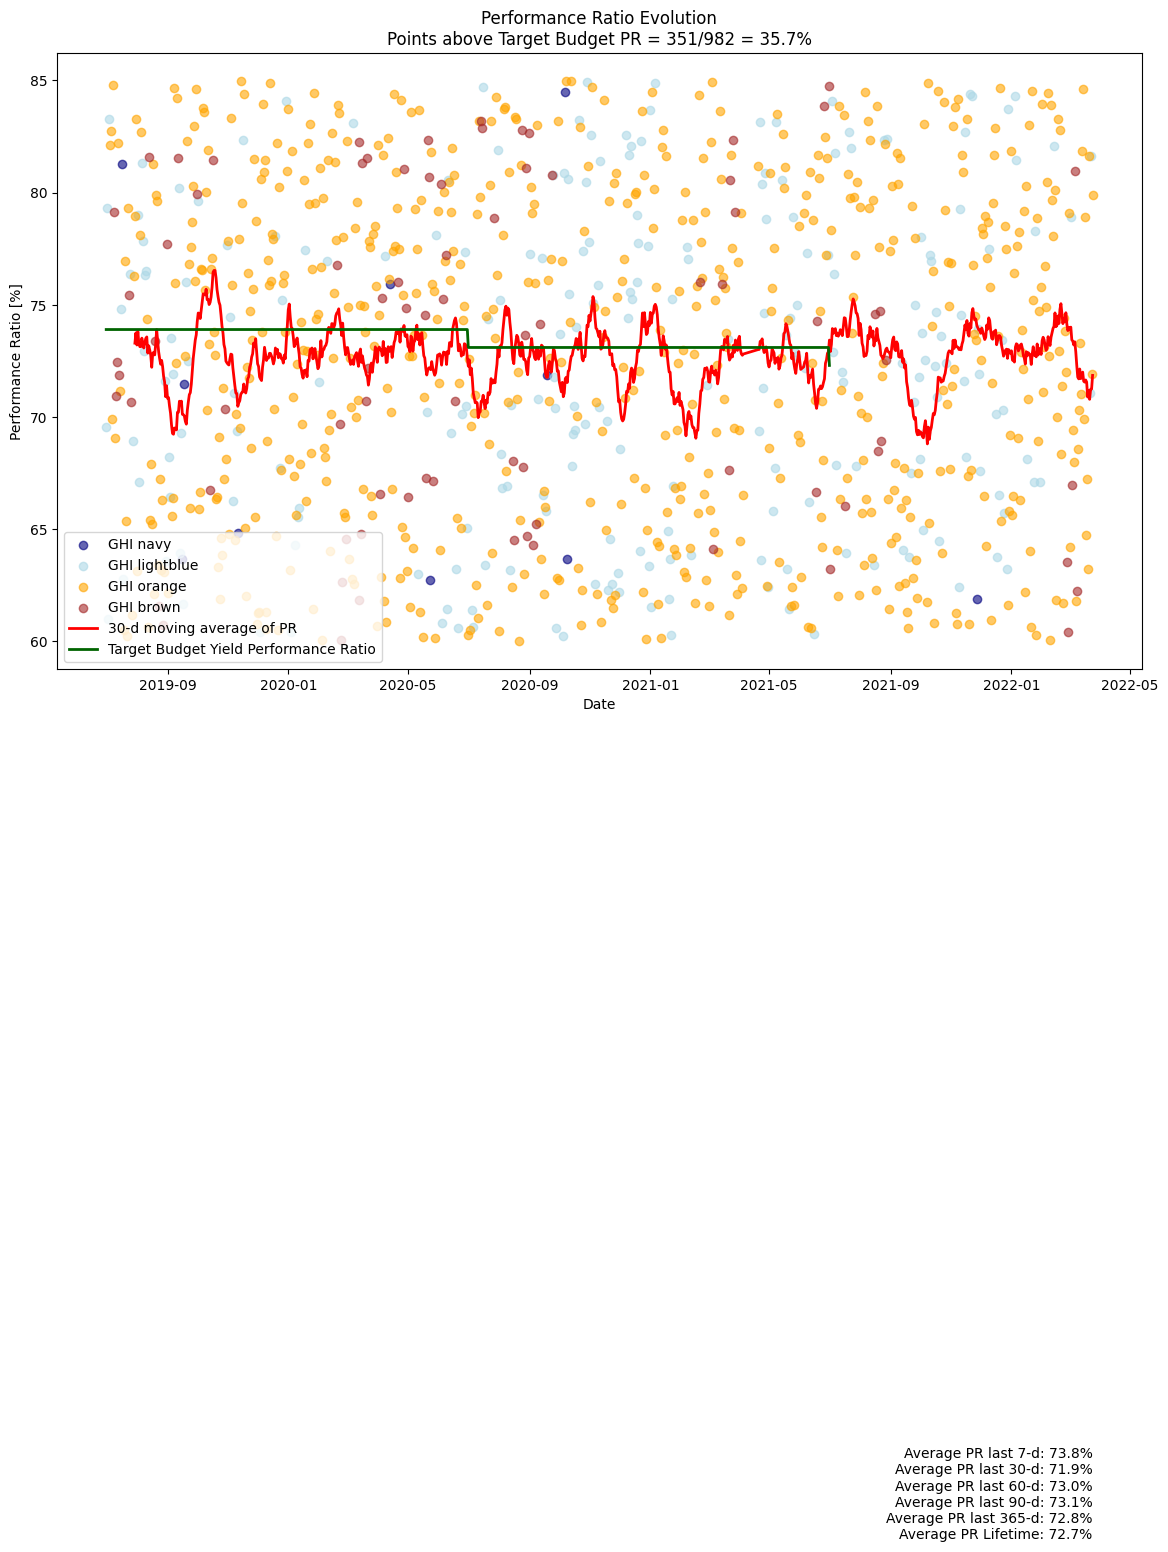

In [84]:
generate_performance_ratio_graph(data)